<a href="https://www.kaggle.com/code/parisrohan/rp-space-titanic-1?scriptVersionId=91674970" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


## Load data and required libraries

In [2]:
#Load the required librares
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.model_selection import train_test_split
%matplotlib inline

pd.pandas.set_option('display.max_columns',None)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')


In [3]:
#Load training dataset
df_train=pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
#Load test dataset
df_test=pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [5]:
#Check submission file
df_submission=pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
df_submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


## EDA

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [8]:
df_train.shape, df_test.shape

((8693, 14), (4277, 13))

**Feature Description**:

* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

* Destination - The planet the passenger will be debarking to.

* Age - The age of the passenger.

* VIP - Whether the passenger has paid for special VIP service during the voyage.

* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

* Name - The first and last names of the passenger.

* **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

Text(0.5, 1.0, 'Distribution of target feature')

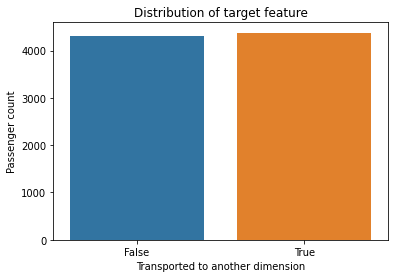

In [9]:
#distribution of values in target feature
sns.barplot(x=df_train['Transported'].value_counts().index, y=df_train['Transported'].value_counts().values, data=df_train)
plt.xlabel('Transported to another dimension')
plt.ylabel('Passenger count')
plt.title('Distribution of target feature')

Observation: The training dataset is a **Balanced dataset**.

Text(0.5, 1.0, 'Distribution of target feature - homeplanet')

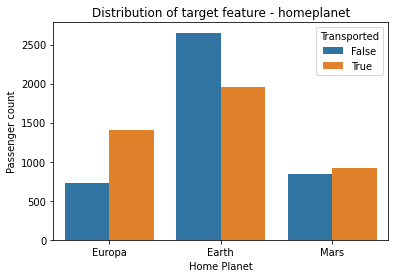

In [10]:
#distribution of values in target feature for each planet
sns.countplot(x='HomePlanet', data=df_train, hue='Transported')
plt.xlabel('Home Planet')
plt.ylabel('Passenger count')
plt.title('Distribution of target feature - homeplanet')

Text(0.5, 1.0, 'Distribution of target feature - ticket class')

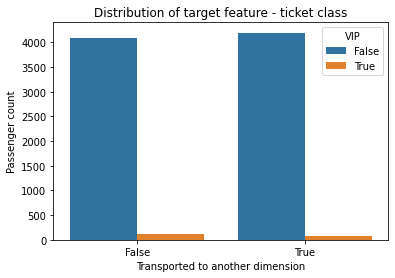

In [11]:
#distribution of values in target feature based on ticket class
sns.countplot(x='Transported', data=df_train, hue='VIP')
plt.xlabel('Transported to another dimension')
plt.ylabel('Passenger count')
plt.title('Distribution of target feature - ticket class')

Text(0.5, 1.0, 'Destination of Passengers')

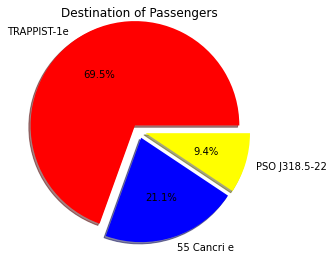

In [12]:
label = df_train['Destination'].value_counts().index
size  = df_train['Destination'].value_counts().values
color = ['Red', 'Blue', 'Yellow']
e     = [0.08,0.08,0.08]

plt.pie(size, labels=label, colors=color, radius=1.2, shadow=True, explode=e, autopct='%1.1f%%')
plt.title('Destination of Passengers')

In [13]:
df_train['Destination'].value_counts().values

array([5915, 1800,  796])

## Data preprocessing

In [14]:
#combine train and test data for data preprocessing
df_merge=pd.concat([df_test.assign(ind="test"), df_train.assign(ind="train")])
df_merge.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,ind,Transported
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,test,NaN
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,test,NaN
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,test,NaN
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,test,NaN
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,test,NaN


In [15]:
df_merge.shape

(12970, 15)

In [16]:
df_merge['Transported']=df_merge['Transported'].astype('object')

### Handle missing values

In [17]:
#Functon to get count of missing values in each column
def get_cols_with_missing_values(DataFrame):
    missing_na_columns=(DataFrame.isnull().sum())
    return missing_na_columns[missing_na_columns > 0]

In [18]:
#Get count of missing values - ignore 4277 records from 'Transported' as it is target feature
print(get_cols_with_missing_values(df_merge))

HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64


In [19]:
#Drop unwanted feature
df_merge.drop(["Name"], axis=1, inplace=True)

In [20]:
#We will impute a '0' value for the luxury amenities as a NULL value might indicate that the passenger has not used them
bill_luxury_amenity=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_merge[bill_luxury_amenity]=df_merge[bill_luxury_amenity].fillna(0)

In [21]:
#Get categorical and numerical columns
categorical_cols=[cname for cname in df_merge.columns if df_merge[cname].dtypes=='object' and cname!='Transported']
numerical_cols=[cname for cname in df_merge.columns if df_merge[cname].dtypes!='object']

In [22]:
#Handling Missing Values in Categorical features by replacing them with the feature mode value
for col in categorical_cols:
    df_merge[col] = df_merge[col].fillna(df_merge[col].mode()[0])

In [23]:
#Handling Missing Values in numerical features by replacing them with the feature mean value
for col in numerical_cols:
    df_merge[col] = df_merge[col].fillna(df_merge[col].mean())

In [24]:
#Make sure all the missing values have been handled- ignore 4277 records from 'Transported' as it is target feature
print(get_cols_with_missing_values(df_merge))

Transported    4277
dtype: int64


### Feature Engineering

In [25]:
new_df = df_merge['PassengerId'].str.split('_',expand = True)
df_merge['Passenger_Group'] = new_df[0]
df_merge['Passenger_Number_in_Group'] = new_df[1]
df_merge.drop(["PassengerId"], axis=1, inplace=True)

In [26]:
df_merge[['Deck','Num','Side']] = df_merge['Cabin'].str.split('/',expand=True)
df_merge.drop(["Cabin"], axis=1, inplace=True)

In [27]:
df_merge.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,ind,Transported,Passenger_Group,Passenger_Number_in_Group,Deck,Num,Side
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,test,NaN,0013,01,G,3,S
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,test,NaN,0018,01,F,4,S
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,test,NaN,0019,01,C,0,S
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,test,NaN,0021,01,C,1,S
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,test,NaN,0023,01,F,5,S


In [28]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HomePlanet                 12970 non-null  object 
 1   CryoSleep                  12970 non-null  bool   
 2   Destination                12970 non-null  object 
 3   Age                        12970 non-null  float64
 4   VIP                        12970 non-null  bool   
 5   RoomService                12970 non-null  float64
 6   FoodCourt                  12970 non-null  float64
 7   ShoppingMall               12970 non-null  float64
 8   Spa                        12970 non-null  float64
 9   VRDeck                     12970 non-null  float64
 10  ind                        12970 non-null  object 
 11  Transported                8693 non-null   object 
 12  Passenger_Group            12970 non-null  object 
 13  Passenger_Number_in_Group  12970 non-null  obje

In [29]:
#change data-type to int for required features
df_merge['Num']=df_merge['Num'].astype('int')
df_merge['Passenger_Number_in_Group']=df_merge['Passenger_Number_in_Group'].astype('int')
df_merge['VRDeck']=df_merge['VRDeck'].astype('int')
df_merge['Spa']=df_merge['Spa'].astype('int')
df_merge['ShoppingMall']=df_merge['ShoppingMall'].astype('int')
df_merge['FoodCourt']=df_merge['FoodCourt'].astype('int')
df_merge['RoomService']=df_merge['RoomService'].astype('int')
df_merge['Age']=df_merge['Age'].astype('int')

df_merge['Passenger_Group']=df_merge['Passenger_Group'].astype('object')
df_merge['VIP']=df_merge['VIP'].astype('object')
df_merge['CryoSleep']=df_merge['CryoSleep'].astype('object')

### Feature Encoding

In [30]:
df_merge.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'ind', 'Transported',
       'Passenger_Group', 'Passenger_Number_in_Group', 'Deck', 'Num', 'Side'],
      dtype='object')

In [31]:
#Get categorical and numerical columns
categorical_cols=[cname for cname in df_merge.columns if df_merge[cname].dtypes=='object' and cname not in ('Transported', 'ind') and df_merge[cname].nunique() < 10]
numerical_cols=[cname for cname in df_merge.columns if df_merge[cname].dtypes!='object']

In [32]:
df_merge.drop(["Passenger_Group"], axis=1, inplace=True)

In [33]:
df_merge[numerical_cols].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Passenger_Number_in_Group,Num
count,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000
mean,28.755898,218.378026,441.890979,170.779491,301.722282,300.450270,1.511488,593.375482
std,14.237137,641.766201,1568.038076,584.153630,1118.746785,1168.655639,1.042500,511.297918
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,160.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,409.000000
75%,37.000000,42.750000,62.750000,23.000000,50.000000,36.000000,2.000000,992.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,8.000000,1894.000000


In [34]:
skew_df = pd.DataFrame(numerical_cols, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df_merge[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,Age,0.448094,0.448094,False
1,RoomService,6.200653,6.200653,True
2,FoodCourt,7.130414,7.130414,True
3,ShoppingMall,11.126048,11.126048,True
4,Spa,7.736207,7.736207,True
5,VRDeck,8.142285,8.142285,True
6,Passenger_Number_in_Group,2.767697,2.767697,True
7,Num,0.741930,0.741930,True


In [35]:
#Apply log1p transformation
for column in skew_df.query("Skewed == True")['Feature'].values:
    df_merge[column] = np.log1p(df_merge[column])

In [36]:
df_merge['CryoSleep'] = df_merge['CryoSleep'].map({False:0,True:1})
df_merge['VIP'] = df_merge['VIP'].map({False:0,True:1})

In [37]:
cat_remaining_to_encode = [col for col in categorical_cols if col not in ('CryoSleep', 'VIP')] 
df_merge_dummies = pd.get_dummies(df_merge[cat_remaining_to_encode],drop_first=True)
df_merge.drop(cat_remaining_to_encode,axis=1,inplace=True)
df_merge = pd.concat([df_merge,df_merge_dummies],axis=1)

## Split train and test data

In [38]:
#split test and train data
test, train= df_merge[df_merge["ind"].eq("test")], df_merge[df_merge["ind"].eq("train")]
test.drop(["Transported", "ind"], axis=1, inplace=True)
train.drop(["ind"], axis=1, inplace=True)

In [39]:
train.shape, test.shape

((8693, 23), (4277, 22))

In [40]:
X = train.loc[:, train.columns!='Transported']
y = train['Transported']

In [41]:
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_valid.shape, y_valid.shape)

Train (6085, 22) (6085,)
Test (2608, 22) (2608,)


### Building a model

In [42]:
model=XGBClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=-1)
model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=False)

[15:27:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
y_pred=model.predict(X_valid)

## Make test predictions

In [44]:
pred_test=model.predict(test)

In [45]:
# Save test predictions to file
output = pd.DataFrame({'PassengerId': df_test.PassengerId,
                       'Transported': pred_test})
output.to_csv('submission.csv', index=False)